In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Load the games data
games = pd.read_csv('games.csv')

# Load the teams data
teams = pd.read_csv('teams.csv')

# Filter out the 2022 season as per your request
games = games[games['SEASON'] != 2022]
games = games.dropna()
# Convert GAME_DATE_EST to datetime
games['GAME_DATE_EST'] = pd.to_datetime(games['GAME_DATE_EST'])

# Sort games by date
games = games.sort_values('GAME_DATE_EST')

# Reset index
games.reset_index(drop=True, inplace=True)


In [4]:
# Split the data into training (up to 2020) and testing (2021 season)
train_games = games[games['SEASON'] <= 2020]
test_games = games[games['SEASON'] == 2021]

print("Training data shape:", train_games.shape)
print("Testing data shape:", test_games.shape)


Training data shape: (24621, 21)
Testing data shape: (1389, 21)


In [5]:
def compute_rolling_averages(df, team_id_col, stats_cols, window=5):
    df = df.sort_values('GAME_DATE_EST')
    df_list = []
    
    for team_id in df[team_id_col].unique():
        team_df = df[df[team_id_col] == team_id]
        team_df = team_df.sort_values('GAME_DATE_EST')
        
        # Compute rolling averages
        rolling_stats = team_df[stats_cols].rolling(window, min_periods=1).mean().shift(1)
        
        # Merge rolling stats with team_df
        team_df = team_df.assign(**{f'rolling_{col}': rolling_stats[col] for col in stats_cols})
        
        df_list.append(team_df)
    
    return pd.concat(df_list)


In [6]:
# Define stats columns to compute rolling averages for
stats_cols_home = ['FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home']
stats_cols_away = ['FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away']

# Compute rolling averages for home teams
train_games = compute_rolling_averages(train_games, 'TEAM_ID_home', stats_cols_home)
train_games = compute_rolling_averages(train_games, 'TEAM_ID_away', stats_cols_away)

# For test_games, we need to be careful to avoid data leakage
test_games = compute_rolling_averages(test_games, 'TEAM_ID_home', stats_cols_home)
test_games = compute_rolling_averages(test_games, 'TEAM_ID_away', stats_cols_away)

In [7]:
# Fill missing rolling averages with overall mean from training data
rolling_cols_home = [f'rolling_{col}' for col in stats_cols_home]
rolling_cols_away = [f'rolling_{col}' for col in stats_cols_away]

train_games[rolling_cols_home] = train_games[rolling_cols_home].fillna(train_games[rolling_cols_home].mean())
train_games[rolling_cols_away] = train_games[rolling_cols_away].fillna(train_games[rolling_cols_away].mean())

test_games[rolling_cols_home] = test_games[rolling_cols_home].fillna(train_games[rolling_cols_home].mean())
test_games[rolling_cols_away] = test_games[rolling_cols_away].fillna(train_games[rolling_cols_away].mean())


In [8]:
# Features: team IDs (encoded) and rolling averages
features = ['TEAM_ID_home', 'TEAM_ID_away'] + rolling_cols_home + rolling_cols_away

# For simplicity, we'll encode team IDs
team_ids = pd.concat([train_games['TEAM_ID_home'], train_games['TEAM_ID_away']]).unique()
team_id_mapping = {team_id: idx for idx, team_id in enumerate(team_ids)}

# Map team IDs to integers
train_games['TEAM_ID_home_enc'] = train_games['TEAM_ID_home'].map(team_id_mapping)
train_games['TEAM_ID_away_enc'] = train_games['TEAM_ID_away'].map(team_id_mapping)

test_games['TEAM_ID_home_enc'] = test_games['TEAM_ID_home'].map(team_id_mapping)
test_games['TEAM_ID_away_enc'] = test_games['TEAM_ID_away'].map(team_id_mapping)

# Update features with encoded team IDs
features = ['TEAM_ID_home_enc', 'TEAM_ID_away_enc'] + rolling_cols_home + rolling_cols_away

# Targets for stats prediction
stats_targets_home = stats_cols_home
stats_targets_away = stats_cols_away


In [9]:
# Prepare training data for home team stats prediction
X_train_stats_home = train_games[features]
y_train_stats_home = train_games[stats_targets_home]

# Prepare test data
X_test_stats_home = test_games[features]


In [10]:
# Initialize and train the model
stats_model_home = RandomForestRegressor(n_estimators=100, random_state=42)
stats_model_home.fit(X_train_stats_home, y_train_stats_home)


RandomForestRegressor(random_state=42)

In [11]:
# Predict stats for home teams
stats_pred_home = stats_model_home.predict(X_test_stats_home)

# Add predicted stats to test_games without the 'pred_' prefix
for idx, col in enumerate(stats_targets_home):
    test_games[col] = stats_pred_home[:, idx]

In [12]:
# Prepare training data for away team stats prediction
X_train_stats_away = train_games[features]
y_train_stats_away = train_games[stats_targets_away]

# Prepare test data
X_test_stats_away = test_games[features]


In [13]:
# Initialize and train the model
stats_model_away = RandomForestRegressor(n_estimators=100, random_state=42)
stats_model_away.fit(X_train_stats_away, y_train_stats_away)


RandomForestRegressor(random_state=42)

In [14]:
# Predict stats for away teams
stats_pred_away = stats_model_away.predict(X_test_stats_away)

# Add predicted stats to test_games without the 'pred_' prefix
for idx, col in enumerate(stats_targets_away):
    test_games[col] = stats_pred_away[:, idx]

Step 2: Predict Actual Scores Using Predicted Stats
Now that we have predicted stats for both teams, we'll use them to predict the actual points scored.


In [15]:
# Features: predicted stats (no 'pred_' prefix now)
predicted_stats_cols_home = stats_targets_home
predicted_stats_cols_away = stats_targets_away

# Prepare training data
train_games['TEAM_ID_home_enc'] = train_games['TEAM_ID_home'].map(team_id_mapping)
train_games['TEAM_ID_away_enc'] = train_games['TEAM_ID_away'].map(team_id_mapping)

# Use actual stats for training
X_train_points = train_games[features + stats_targets_home + stats_targets_away]
y_train_points = train_games[['PTS_home', 'PTS_away']]

# For testing, use predicted stats (no 'pred_' prefix)
X_test_points = test_games[features + predicted_stats_cols_home + predicted_stats_cols_away]

In [16]:
# Initialize and train the model
points_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
points_model.fit(X_train_points, y_train_points)


MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

In [17]:
# Predict points for test set
points_pred = points_model.predict(X_test_points)

# Add predicted points to test_games
test_games['PTS_home_pred'] = points_pred[:, 0]
test_games['PTS_away_pred'] = points_pred[:, 1]


In [18]:
# Determine predicted winners
test_games['HOME_TEAM_WINS_pred'] = np.where(
    test_games['PTS_home_pred'] > test_games['PTS_away_pred'], 1, 0)


In [19]:
# Calculate MAE for score predictions
mae_home = mean_absolute_error(test_games['PTS_home'], test_games['PTS_home_pred'])
mae_away = mean_absolute_error(test_games['PTS_away'], test_games['PTS_away_pred'])

print(f"Mean Absolute Error for Home Team Points: {mae_home:.2f}")
print(f"Mean Absolute Error for Away Team Points: {mae_away:.2f}")


Mean Absolute Error for Home Team Points: 10.42
Mean Absolute Error for Away Team Points: 10.43


In [20]:
# Calculate accuracy for winner predictions
accuracy = accuracy_score(test_games['HOME_TEAM_WINS'], test_games['HOME_TEAM_WINS_pred'])
print(f"Accuracy for predicting winner: {accuracy * 100:.2f}%")


Accuracy for predicting winner: 58.10%


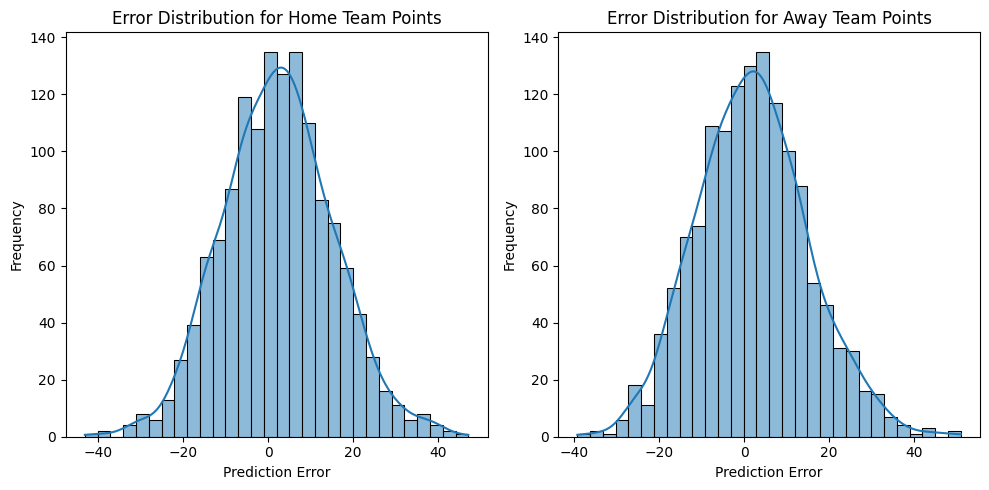

In [21]:
# Calculate errors
test_games['Error_home'] = test_games['PTS_home'] - test_games['PTS_home_pred']
test_games['Error_away'] = test_games['PTS_away'] - test_games['PTS_away_pred']

# Histogram of errors
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(test_games['Error_home'], kde=True)
plt.title('Error Distribution for Home Team Points')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(test_games['Error_away'], kde=True)
plt.title('Error Distribution for Away Team Points')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [22]:
# Map team IDs to names
team_id_to_name = teams.set_index('TEAM_ID')['NICKNAME'].to_dict()
test_games['HOME_TEAM_NAME'] = test_games['TEAM_ID_home'].map(team_id_to_name)
test_games['VISITOR_TEAM_NAME'] = test_games['TEAM_ID_away'].map(team_id_to_name)

# Select relevant columns
output_columns = [
    'GAME_DATE_EST', 'HOME_TEAM_NAME', 'VISITOR_TEAM_NAME',
    'PTS_home_pred', 'PTS_away_pred', 'HOME_TEAM_WINS_pred'
]

predicted_results = test_games[output_columns]

# Round the predicted points
predicted_results['PTS_home_pred'] = predicted_results['PTS_home_pred'].round(1)
predicted_results['PTS_away_pred'] = predicted_results['PTS_away_pred'].round(1)



/var/folders/mz/57q3hbkj3gldm03rnq8cj4_c0000gn/T/ipykernel_969/3044327826.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_results['PTS_home_pred'] = predicted_results['PTS_home_pred'].round(1)
/var/folders/mz/57q3hbkj3gldm03rnq8cj4_c0000gn/T/ipykernel_969/3044327826.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_results['PTS_away_pred'] = predicted_results['PTS_away_pred'].round(1)


In [23]:
predicted_results

,GAME_DATE_EST,HOME_TEAM_NAME,VISITOR_TEAM_NAME,PTS_home_pred,PTS_away_pred,HOME_TEAM_WINS_pred
24621,2021-10-03,Lakers,Nets,96.5,92.9,1
24663,2021-10-11,76ers,Nets,107.2,104.4,1
24688,2021-10-19,Bucks,Nets,114.1,110.3,1
24712,2021-10-22,76ers,Nets,101.8,101.8,0
24812,2021-11-05,Pistons,Nets,104.3,105.0,0
...,...,...,...,...,...,...
25982,2022-05-10,Suns,Mavericks,103.8,104.7,0
25990,2022-05-15,Suns,Mavericks,104.5,103.5,1
25993,2022-05-18,Warriors,Mavericks,107.8,103.3,1
25995,2022-05-20,Warriors,Mavericks,107.2,106.2,1


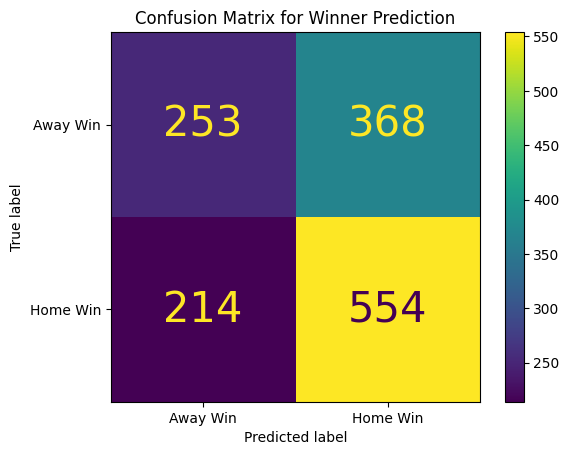

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(test_games['HOME_TEAM_WINS'], test_games['HOME_TEAM_WINS_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Away Win', 'Home Win'])
disp.plot(cmap='viridis', text_kw={'fontsize': 30})
plt.title('Confusion Matrix for Winner Prediction')
plt.show()


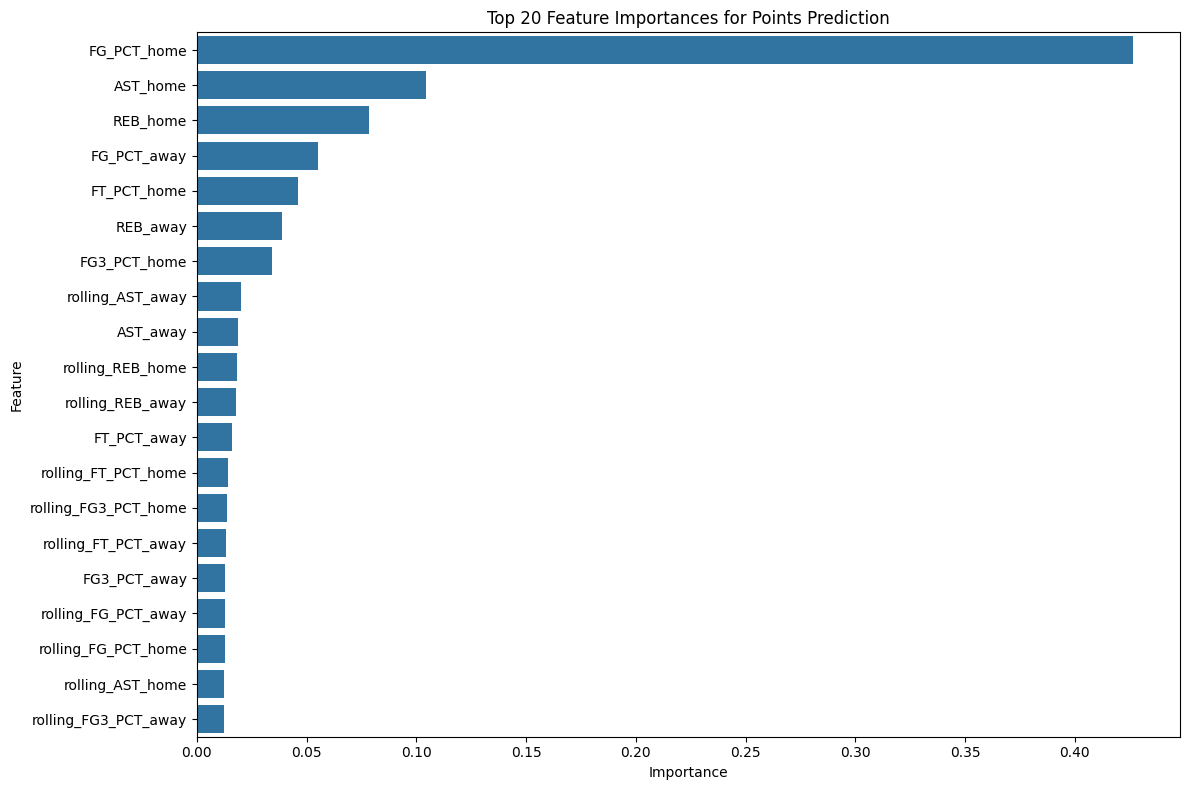

In [27]:
# For the points prediction model
# Since we used a MultiOutputRegressor, we'll extract feature importances from one of the estimators
feature_importances = points_model.estimators_[0].feature_importances_

# Get feature names
feature_names = X_train_points.columns

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
plt.title('Top 20 Feature Importances for Points Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


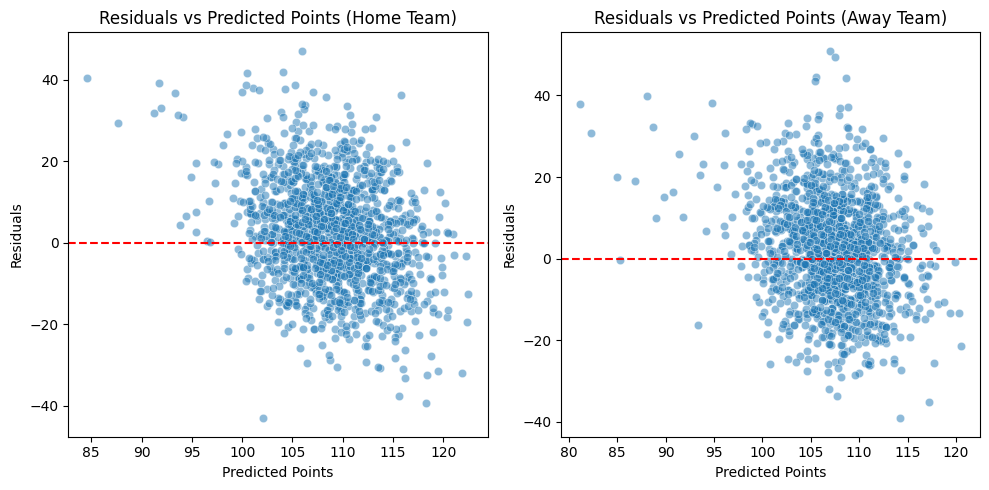

In [28]:
# Residuals for home team points
test_games['Residual_home'] = test_games['PTS_home'] - test_games['PTS_home_pred']

# Residuals for away team points
test_games['Residual_away'] = test_games['PTS_away'] - test_games['PTS_away_pred']

# Plot residuals for home team points
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=test_games['PTS_home_pred'], y=test_games['Residual_home'], alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Points (Home Team)')
plt.xlabel('Predicted Points')
plt.ylabel('Residuals')

# Plot residuals for away team points
plt.subplot(1, 2, 2)
sns.scatterplot(x=test_games['PTS_away_pred'], y=test_games['Residual_away'], alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Points (Away Team)')
plt.xlabel('Predicted Points')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()


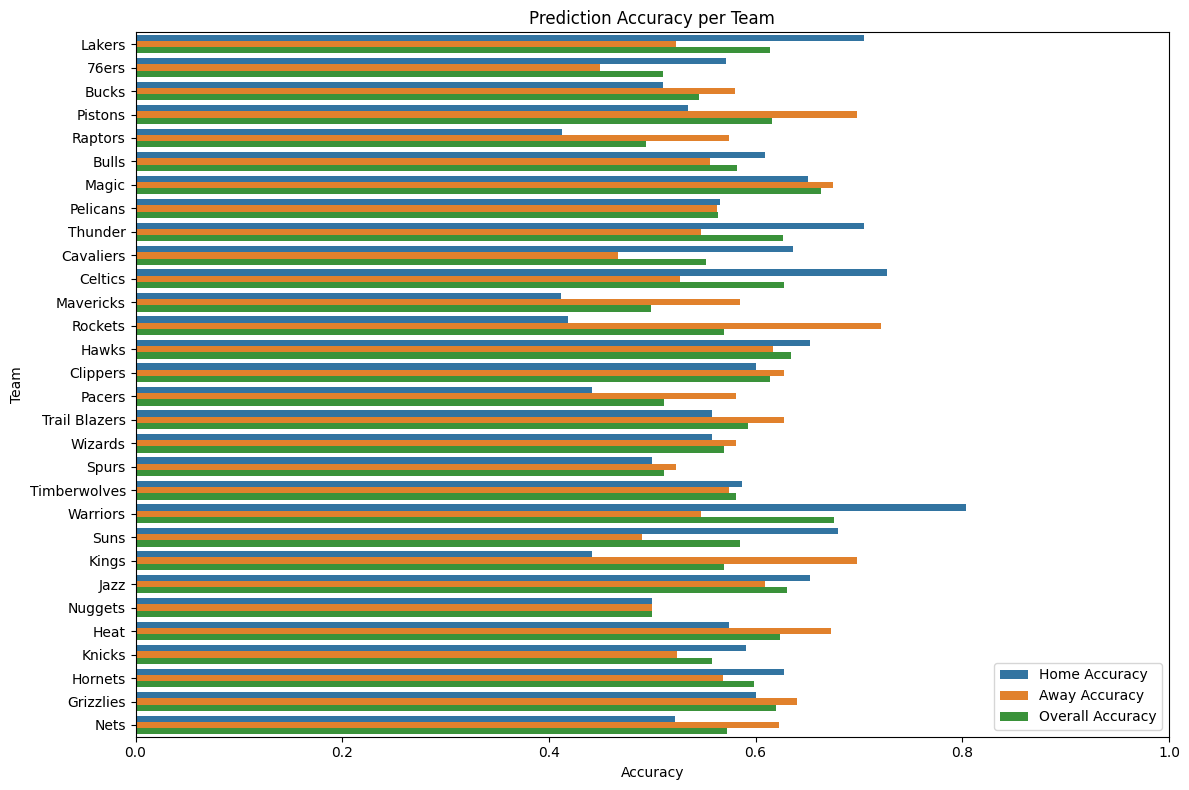

In [29]:
# Function to compute accuracy for each team
def compute_team_accuracy(df, team_col, actual_col, pred_col):
    accuracies = {}
    for team in df[team_col].unique():
        team_df = df[df[team_col] == team]
        acc = accuracy_score(team_df[actual_col], team_df[pred_col])
        accuracies[team] = acc
    return accuracies

# Compute accuracy for home teams
home_team_accuracies = compute_team_accuracy(test_games, 'HOME_TEAM_NAME', 'HOME_TEAM_WINS', 'HOME_TEAM_WINS_pred')
home_accuracy_df = pd.DataFrame(list(home_team_accuracies.items()), columns=['Team', 'Home Accuracy'])

# Compute accuracy for away teams (invert the win indicator)
test_games['AWAY_TEAM_WINS'] = 1 - test_games['HOME_TEAM_WINS']
test_games['AWAY_TEAM_WINS_pred'] = 1 - test_games['HOME_TEAM_WINS_pred']
away_team_accuracies = compute_team_accuracy(test_games, 'VISITOR_TEAM_NAME', 'AWAY_TEAM_WINS', 'AWAY_TEAM_WINS_pred')
away_accuracy_df = pd.DataFrame(list(away_team_accuracies.items()), columns=['Team', 'Away Accuracy'])

# Merge home and away accuracies
team_accuracy_df = pd.merge(home_accuracy_df, away_accuracy_df, on='Team')

# Calculate overall accuracy
team_accuracy_df['Overall Accuracy'] = (team_accuracy_df['Home Accuracy'] + team_accuracy_df['Away Accuracy']) / 2

# Melt for plotting
accuracy_melted = team_accuracy_df.melt(id_vars='Team', value_vars=['Home Accuracy', 'Away Accuracy', 'Overall Accuracy'],
                                        var_name='Game Type', value_name='Accuracy')

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=accuracy_melted, x='Accuracy', y='Team', hue='Game Type')
plt.title('Prediction Accuracy per Team')
plt.xlabel('Accuracy')
plt.ylabel('Team')
plt.xlim(0, 1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
